## Pandas IV: Aggregation, Grouping and Pivot Tables

*Disclaimer: The contents of this notebook are developped according to Python Data Science Handbook, by Jake VanderPlas and Python for Data Analysis, by Wes McKinney*

In [2]:
import numpy as np
import pandas as pd

An essential piece of analysis of large data is efficient summarization: computing aggregations like `sum()`, `mean()`, `median()`, `min()`, and `max()`, in which a single number gives insight into the nature of a potentially large dataset. In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a `groupby`

### Simple Aggregation in Pandas
As with a one-dimensional NumPy `array`, for a Pandas `Series` the aggregates return a single value

In [2]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [3]:
ser.sum()

2.811925491708157

In [4]:
ser.mean()

0.5623850983416314

For a `DataFrame`, by default the aggregates return results within each column

In [5]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [6]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

By specifying the `axis` argument, you can instead aggregate within each row

In [7]:
df.mean(axis = 'columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas `Series` and `DataFrames` include all of the common aggregates mentioned earlier. In addition, there is a convenience method `describe()` that computes several common aggregates for each column and returns the result. Let's use this on the Planets data from seaborn, for now dropping rows with missing values

In [23]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [9]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [10]:
planets.isnull().any()

method            False
number            False
orbital_period     True
mass               True
distance           True
year              False
dtype: bool

In [11]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


The following table summarizes some other built-in Pandas aggregations. These are all methods of `DataFrame` and `Series` objects

<div>
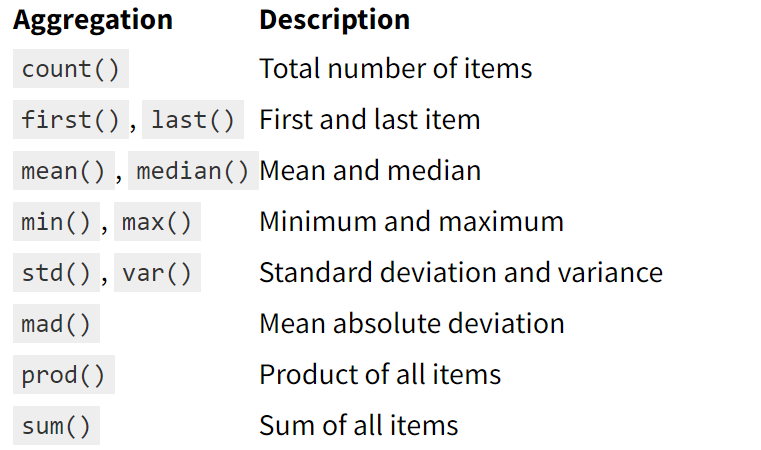
</div>

### GroupBy: Split, Apply, Combine
Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called groupby operation.
    
The figure below makes clear what the `groupby` accomplishes

<div>
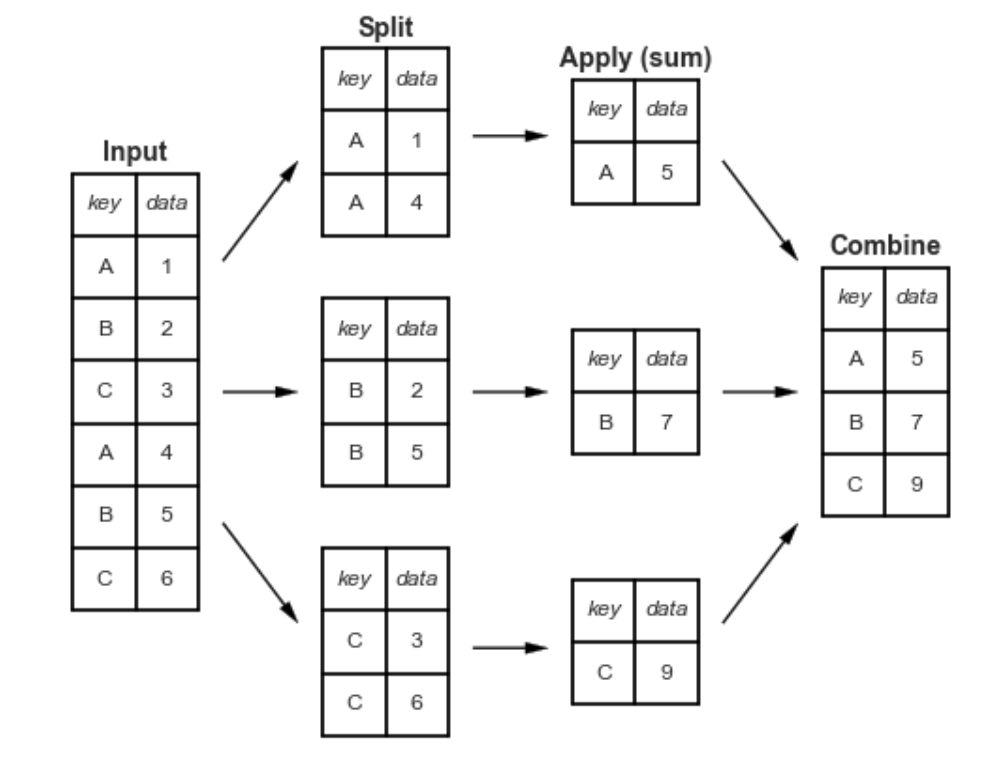
</div>

- The split step involves breaking up and grouping a `DataFrame` depending on the value of the specified `key`
- The apply step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups
- The combine step merges the results of these operations into an output array

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram. We'll start by creating the input `DataFrame`

In [12]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns = ['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


The most basic split-apply-combine operation can be computed with the `groupby()` method of `DataFrames`, passing the name of the desired `key` column

In [13]:
df.groupby('key')

Notice that what is returned is not a set of `DataFrames`, but a `DataFrameGroupBy` object. This object is where the magic is: you can think of it as a special view of the `DataFrame`, which is poised to dig into the groups but does no actual computation until the aggregation is applied.

To produce a result, we can apply an aggregate to this `DataFrameGroupBy` object, which will perform the appropriate apply/combine steps to produce the desired result

In [14]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


The `sum()` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid `DataFrame` operation

### The GroupBy Object
The `GroupBy` object is a very flexible abstraction. In many ways, you can simply treat it as if it's a collection of `DataFrames`, and it does the difficult things under the hood. The most important operations made available by a GroupBy are aggregate, filter, transform, and apply.

#### Column Indexing
Since we can treat the `GroupBy` object as a collections of DataFrames, supports column indexing in the same way as the `DataFrame`, and returns a modified `GroupBy` object

In [15]:
planets.groupby('method')

In [16]:
planets.groupby('method')['orbital_period']

Here we've selected a particular `Series` group from the original `DataFrame` group by reference to its column name. As with the `GroupBy` object, no computation is done until we call some aggregate on the object

In [17]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

#### Iteration Over Groups
The `GroupBy` object supports direct iteration over the groups, returning each group as a `Series` or `DataFrame`. The `Groupby` object generates a sequence of 2-tuples containing the group name along with the chunk of the data (a new DataFrame)

In [18]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape = {1}\n {2}".format(method, group.shape, group))

Astrometry                     shape = (2, 6)
          method  number  orbital_period  mass  distance  year
113  Astrometry       1          246.36   NaN     20.77  2013
537  Astrometry       1         1016.00   NaN     14.98  2010
Eclipse Timing Variations      shape = (9, 6)
                        method  number  orbital_period  mass  distance  year
32  Eclipse Timing Variations       1        10220.00  6.05       NaN  2009
37  Eclipse Timing Variations       2         5767.00   NaN    130.72  2008
38  Eclipse Timing Variations       2         3321.00   NaN    130.72  2008
39  Eclipse Timing Variations       2         5573.55   NaN    500.00  2010
40  Eclipse Timing Variations       2         2883.50   NaN    500.00  2010
41  Eclipse Timing Variations       1         2900.00   NaN       NaN  2011
42  Eclipse Timing Variations       1         4343.50  4.20       NaN  2012
43  Eclipse Timing Variations       2         5840.00   NaN       NaN  2011
44  Eclipse Timing Variations       

In [19]:
# retrieve a group using get_group
planets.groupby('method').get_group('Imaging')

,method,number,orbital_period,mass,distance,year
29,Imaging,1,NaN,NaN,45.52,2005
30,Imaging,1,NaN,NaN,165.00,2007
31,Imaging,1,NaN,NaN,140.00,2004
33,Imaging,1,NaN,NaN,NaN,2008
34,Imaging,1,NaN,NaN,145.00,2013
35,Imaging,1,NaN,NaN,139.00,2004
36,Imaging,1,NaN,NaN,18.39,2006
47,Imaging,1,6000.00,NaN,19.28,2008
54,Imaging,1,NaN,NaN,52.03,2012
68,Imaging,1,318280.00,NaN,7.69,2008


#### Dispatch Methods
Any common Pandas or NumPy aggregation functions, as well as any valid Pandas `Series` and `DataFrame` operation can be applied to the `GroupBy` object. For example, you can use the `describe()` method of DataFrames to perform a set of aggregations that describe each group in the data

In [20]:
planets.groupby('method')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


Notice that the operations are applied to each individual group, and the results are then combined within `GroupBy` and returned. Again, any valid `DataFrame/Series` method can be used on the corresponding `GroupBy` object, which allows for some very flexible and powerful operations!

#### Aggregation
We're now familiar with `GroupBy` aggregations with `sum()`, `median()`, and the like, but the `aggregate()` method allows for even more flexibility. It can take a string, a function, or a list thereof, and compute all the aggregates at once.

`DataFrame.aggregate(func = None, axis = 0, *args, **kwargs)`

- `func`: Function to use for aggregating the data. Accepted combinations are: function, string function name, list of functions and/or function names, e.g. `[np.sum, 'mean']`, dict of axis labels -> functions, function names or list of such
- `axis`: {0 or ‘index’, 1 or ‘columns’}, default 0. If 0 or ‘index’: apply function to each column. If 1 or ‘columns’: apply function to each row

In [21]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key1': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'key2': ['foo', 'bar', 'foo', 'foo', 'bar', 'bar'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key1', 'key2', 'data1', 'data2'])
df

,key1,key2,data1,data2
0,A,foo,0,5
1,B,bar,1,0
2,C,foo,2,3
3,A,foo,3,3
4,B,bar,4,7
5,C,bar,5,9


In [22]:
df.groupby('key1').aggregate(['min', np.median, max])

data1            data2           
       min median max   min median max
key1                                  
A        0    1.5   3     3    4.0   5
B        1    2.5   4     0    3.5   7
C        2    3.5   5     3    6.0   9

You may have noticed that there is no `key2` column in the result because `key2` column contains non-numeric data. By default, all of the numeric columns (e.g., `data1` and `data2`) are aggregated.

As you can also see, the resulting `DataFrame` has hierarchical column indexes. You do not need to accept the names that `Groupby` gives to the columns. If you pass a list of `(name, function)` tuples, the first element of each tuple will be used as the DataFrame column names (you can think of a list of 2-tuples as an ordered mapping)

In [23]:
df.groupby('key1').agg([('foo', 'min'), ('bar', np.median), ('baz', max)])

data1          data2         
       foo  bar baz   foo  bar baz
key1                              
A        0  1.5   3     3  4.0   5
B        1  2.5   4     0  3.5   7
C        2  3.5   5     3  6.0   9

We can also group data using multiple keys

In [24]:
df.groupby(['key1', 'key2']).mean()

data1  data2
key1 key2              
A    foo     1.5    4.0
B    bar     2.5    3.5
C    bar     5.0    9.0
     foo     2.0    3.0

In [25]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)
    print()

('A', 'foo')
  key1 key2  data1  data2
0    A  foo      0      5
3    A  foo      3      3

('B', 'bar')
  key1 key2  data1  data2
1    B  bar      1      0
4    B  bar      4      7

('C', 'bar')
  key1 key2  data1  data2
5    C  bar      5      9

('C', 'foo')
  key1 key2  data1  data2
2    C  foo      2      3



In the case of multiple keys, the first element in the tuple will be a tuple of key values

In [26]:
# retrieve a particular group
df.groupby(['key1', 'key2']).get_group(('A', 'foo'))

,key1,key2,data1,data2
0,A,foo,0,5
3,A,foo,3,3


By default, `groupby` groups by rows on `axis = 0`, you can group on any of the other axes. For example, we could group the columns of our example `df` here by `dtype`

In [27]:
df.dtypes

key1     object
key2     object
data1     int64
data2     int64
dtype: object

In [28]:
grouped = df.groupby(df.dtypes, axis = 1) # key length is the same as column numbers

In [29]:
for k, group in grouped:
    print(k)
    print(group)
    print()

int64
   data1  data2
0      0      5
1      1      0
2      2      3
3      3      3
4      4      7
5      5      9

object
  key1 key2
0    A  foo
1    B  bar
2    C  foo
3    A  foo
4    B  bar
5    C  bar



Another useful pattern is to pass a `dictionary` mapping column names to operations to be applied on that column

In [30]:
df.groupby('key1').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key1,,
A,0,5
B,1,7
C,2,9


In [31]:
df.groupby('key1').aggregate({'data1': ['min', 'mean', 'std'],
                             'data2': 'max'})

data1               data2
       min mean      std   max
key1                          
A        0  1.5  2.12132     5
B        1  2.5  2.12132     7
C        2  3.5  2.12132     9

A `DataFrame` will have hierarchical column indexes only if multiple functions are applied to at least one column. In all of the examples up until now, the aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations. You can disable this behavior by passing `as_index = False` to `groupby`

In [32]:
df.groupby('key1').mean()

,data1,data2
key1,,
A,1.5,4.0
B,2.5,3.5
C,3.5,6.0


In [33]:
df.groupby('key1', as_index =  False).mean()

,key1,data1,data2
0,A,1.5,4.0
1,B,2.5,3.5
2,C,3.5,6.0


#### Filtering
A filtering operation allows you to drop data based on the group properties. For example, we might want to keep all groups in which the standard deviation is larger than some critical value. 

In [34]:
def filter_func(x):
    return x['data2'].std() > 4

df

,key1,key2,data1,data2
0,A,foo,0,5
1,B,bar,1,0
2,C,foo,2,3
3,A,foo,3,3
4,B,bar,4,7
5,C,bar,5,9


In [35]:
df.groupby('key1').std()

,data1,data2
key1,,
A,2.12132,1.414214
B,2.12132,4.949747
C,2.12132,4.242641


`df.groupby('key')` is just syntactic sugar for `df.groupby(df['key'])`

In [36]:
df.groupby(df['key1']).std()

,data1,data2
key1,,
A,2.12132,1.414214
B,2.12132,4.949747
C,2.12132,4.242641


In [37]:
df.groupby('key1').filter(filter_func)

,key1,key2,data1,data2
1,B,bar,1,0
2,C,foo,2,3
4,B,bar,4,7
5,C,bar,5,9


The filter function should return a Boolean value specifying whether the group passes the filtering. Here because group A does not have a standard deviation greater than 4, it is dropped from the result

### `apply`: General Split-Apply-Combine
The most general purpose `Groupby` method is `apply`. It lets you apply an arbitray function to the group results. What occurs inside the function passed to `apply` is up to you. It only needs to return a Pandas object or a scalar value. Please keep in mind that the input argument of the function passed to `apply` is a DataFrame. **Please do not be confused with the Series and DataFrame's `apply` method**

- Series's `apply`: the input of the function passed to the `apply` is each value in the Series
- DataFrame's `apply`: the input of the function passed to the `apply` is each row (`axis = 1`) or column (`axis = 0`) of the DataFrame
- Groupby's `apply`: the input of the function passed to the `apply` is a DataFrame

Let's use the tips dataset from Seaborn as an example

In [38]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [39]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


After loading the dataset, we add a tipping percentage column tip_pct

In [40]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


Suppose you wanted to select the top five tip_pct values by group. First, write a function that selects the rows with the largest values in a particular column

In [41]:
# pay attention to the function argument, it must receive a DataFrame
def top(df, n = 5, column = 'tip_pct'):
    return df.sort_values(by = column)[-n:]
top(tips, n = 6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


Now, if we group by smoker and call `apply` with this function

In [42]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990

The `top` function is called on each row group from the DataFrame, and then the results are glued together, labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the orginal DataFrame. In the preceding example, you can see that the resulting object has a hierarchical index formed from the group keys along with the indexes of each pieces of the original DataFrame. You can disbale this by passing `group_keys = False` to `groupby`

In [43]:
tips.groupby('smoker', group_keys = False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990


If you pass a function to `apply` that takes other arguments or keywords, you can pass these after the function

In [44]:
tips.groupby(['smoker', 'day']).apply(top, n = 1, column = 'total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
Yes    Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   
       Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
No     Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
       Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   

                  tip_pct  
smoker day                 
Yes    Thur 197  0.115982  
       Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
No     Thur 142  0.121389  
       Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799

### Specifying the Split Key
In the simple examples presented before, we split the `DataFrame` on a single column name. This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here

#### A List, Array, Series, or Index Providing the Grouping Keys
The key can be any `Series` or list with a length matching that of the `DataFrame`

In [45]:
df

,key1,key2,data1,data2
0,A,foo,0,5
1,B,bar,1,0
2,C,foo,2,3
3,A,foo,3,3
4,B,bar,4,7
5,C,bar,5,9


In [46]:
# three new group keys, 0, 1 and 2
L = [0, 1, 0, 1, 2, 0]
df.groupby(L).sum()

,data1,data2
0,7,17
1,4,3
2,4,7


#### A Dictionary or Series Mapping Index to Group
Another method is to provide a `dictionary` that maps index values to the group keys. A `dictionary` or `Series`, providing a `label -> group name` mapping

In [47]:
df2 = df.set_index('key1')
df2

,key2,data1,data2
key1,,,
A,foo,0,5
B,bar,1,0
C,foo,2,3
A,foo,3,3
B,bar,4,7
C,bar,5,9


In [48]:
# combine B and C into one group
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
df2.groupby(mapping).sum()

,data1,data2
key1,,
consonant,12,19
vowel,3,8


#### Any Python Function
Similar to mapping, you can pass any Python function that will use the DataFrame's index values as input and output the group keys (Any function passed as a group key will be called once per index value, with the return values being used as the group names)

In [49]:
df2

,key2,data1,data2
key1,,,
A,foo,0,5
B,bar,1,0
C,foo,2,3
A,foo,3,3
B,bar,4,7
C,bar,5,9


In [50]:
df2.groupby(str.lower).mean()

,data1,data2
key1,,
a,1.5,4.0
b,2.5,3.5
c,3.5,6.0


#### A List of Valid Keys
Further, any of the preceding key choices can be combined to group on a multi-index

In [51]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
key1,key1,,
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


### Grouping by Index Levels
A final convenience for hierarchically indexed datasets is the ability to aggregate using one of the levels of an axis index

In [52]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names = ['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns = columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.000474 -0.299114  2.233754 -0.072794  0.457251
1      0.870456 -0.566395 -0.625950  0.614980 -0.592766
2     -1.026062  2.270621 -0.328528  1.946090  0.003594
3      1.468184  0.379499  0.185028 -1.019256 -0.208531

To group by level, pass the level number or name using the `level` option

In [53]:
hier_df.groupby(level = 'cty', axis = 1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


Regardless of the objective in using `groupby`, a generally useful groupby method is `size`, which returns a `Series` containing group sizes (the number of rows/columns in each group)

In [54]:
hier_df.groupby(level='cty', axis=1).size()

cty
JP    2
US    3
dtype: int64

### A Grouping Example
As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade

In [55]:
decade = 10 * (planets['year'] // 10)
decade

0       2000
1       2000
2       2010
3       2000
4       2000
        ... 
1030    2000
1031    2000
1032    2000
1033    2000
1034    2000
Name: year, Length: 1035, dtype: int64

In [56]:
# DataFrame.astype(dtype, copy=True, errors='raise')
# Cast a pandas object to a specified dtype
decade = decade.astype(str) + 's'
decade

0       2000s
1       2000s
2       2010s
3       2000s
4       2000s
        ...  
1030    2000s
1031    2000s
1032    2000s
1033    2000s
1034    2000s
Name: year, Length: 1035, dtype: object

In [57]:
decade.name = 'decade'
decade

0       2000s
1       2000s
2       2010s
3       2000s
4       2000s
        ...  
1030    2000s
1031    2000s
1032    2000s
1033    2000s
1034    2000s
Name: decade, Length: 1035, dtype: object

In [58]:
planets.groupby(['method', decade])['number'].sum()

method                         decade
Astrometry                     2010s       2
Eclipse Timing Variations      2000s       5
                               2010s      10
Imaging                        2000s      29
                               2010s      21
Microlensing                   2000s      12
                               2010s      15
Orbital Brightness Modulation  2010s       5
Pulsar Timing                  1990s       9
                               2000s       1
                               2010s       1
Pulsation Timing Variations    2000s       1
Radial Velocity                1980s       1
                               1990s      52
                               2000s     475
                               2010s     424
Transit                        2000s      64
                               2010s     712
Transit Timing Variations      2010s       9
Name: number, dtype: int64

### Pivot Tables
The pivot table takes simple **column-wise** data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data

For the examples in this section, we'll use the database of passengers on the Titanic, available through the Seaborn library

In [36]:
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Let's look at survival rate by gender by using the `GroupBy` method we studies in the previous section

In [37]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


We might like to go one step deeper and look at survival by both sex and, say, class. Using the vocabulary of `GroupBy`, we might proceed using something like this: we group by class and gender, select survival, apply a mean aggregate, combine the resulting groups, and then unstack the hierarchical index to reveal the hidden multidimensionality

In [38]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

In [39]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This two-dimensional `GroupBy` is common enough that Pandas includes a convenience routine, `pivot_table`, which succinctly handles this type of multi-dimensional aggregation

### Pivot Table Syntax

`pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)`

- `data`: DataFrame
- `values`: column to aggregate, optional
- `index`: column, Grouper, array, or list of the previous. If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table index. If an array is passed, it is being used as the same manner as column values
- `columns`: column, Grouper, array, or list of the previous. If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table column. If an array is passed, it is being used as the same manner as column values
- `aggfunc`: function, list of functions, dict, default numpy.mean. If list of functions passed, the resulting pivot table will have hierarchical columns whose top level are the function names (inferred from the function objects themselves) If dict is passed, the key is column to aggregate and value is function or list of functions
- `margins`: bool, default False. Add all row / columns (e.g. for subtotal / grand totals).
- `dropna`: bool, default True. Do not include columns whose entries are all NaN
    
**The `index` and `columns` are mostly from the categorical columns.** Here is the equivalent to the preceding operation using the `pivot_table` method of DataFrames

In [40]:
pd.pivot_table(titanic, 'survived', index = 'sex', columns = 'class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [41]:
titanic.pivot_table('survived', index = 'sex', columns = 'class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [42]:
titanic.pivot_table(['survived', 'fare'], index = 'sex', columns = 'class')

fare                        survived                    
class        First     Second      Third     First    Second     Third
sex                                                                   
female  106.125798  21.970121  16.118810  0.968085  0.921053  0.500000
male     67.226127  19.741782  12.661633  0.368852  0.157407  0.135447

This is eminently more readable than the groupby approach, and produces the same result

### Multi-level Pivot Tables
Just as in the `GroupBy`, the grouping in pivot tables can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimension. We'll bin the age using the `pd.cut` function

In [43]:
# pandas.cut(x, bins, right=True)
# Bin values into discrete intervals
# x: The input array to be binned. Must be 1-dimensional
# bins: The criteria to bin by
# right: Indicates whether bins includes the rightmost edge or not. 
# If right == True (the default), then the bins [1, 2, 3, 4] indicate (1,2], (2,3], (3,4]. 

age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using `pd.qcut` to automatically compute quantiles

In [44]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

The result is a four-dimensional aggregation with hierarchical indices, shown in a grid demonstrating the relationship between the values.

### Additional Pivot Table Options
We've already seen examples of the `pivot_table` by using `values`, `index` and `columns` parameters; here we'll take a quick look at the remaining ones. Two of the options, `fill_value` and `dropna`, have to do with missing data and are fairly straightforward.

The `aggfunc` keyword controls what type of aggregation is applied, which is a mean by default. As in the `GroupBy`, the aggregation specification can be a string representing one of several common choices (e.g., `'sum'`, `'mean'`, `'count'`, `'min'`, `'max'`, etc.) or a function that implements an aggregation (e.g., `np.sum()`, `min()`, `sum()`, etc.). Additionally, it can be specified as a `dictionary` mapping a column to any of the above desired options

In [45]:
titanic.pivot_table(index = 'sex', columns = 'class',
                    aggfunc = {'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the `values` keyword; when specifying a mapping for `aggfunc`, this is determined automatically by the dictionary keys

At times it's useful to compute totals along each grouping. This can be done via the `margins` keyword

In [46]:
titanic.pivot_table('survived', index = 'sex', columns = 'class', margins = True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


### Crosstab
A cross-tabulation is a special case of a pivot table that computes group frequencies

`crosstab(index, columns, values = None, rownames = None, colnames = None, aggfunc = None, margins = False, margins_name = 'All', dropna = True, normalize = False)`

- `index`: Values to group by in the rows
- `columns`: Values to group by in the columns

In [3]:
from io import StringIO
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [4]:
pd.crosstab(data.Nationality, data.Handedness, margins = True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


In [5]:
data1 = data.pivot_table(index = 'Nationality', columns = 'Handedness', aggfunc = 'count', margins = True)
data1

Sample                 
Handedness  Left-handed Right-handed All
Nationality                             
Japan                 2            3   5
USA                   1            4   5
All                   3            7  10

In [6]:
col = pd.Index(['Left-handed', 'Right-handed', 'All'], name = 'Handedness')
col

Index(['Left-handed', 'Right-handed', 'All'], dtype='object', name='Handedness')

In [ ]:
data1.columns = col
data1

### Case Study: Movie Rating
Let's first load the dataset

In [10]:
df = pd.read_csv(
    'ratings.dat',
    sep = '::',
    engine = 'python', 
    names = 'UserID::MovieID::Rating::Timestamp'.split('::')
)
df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Next we will calcuate the average rating for each movie

In [11]:
result = df.groupby('MovieID')['Rating'].mean()
result.head()

MovieID
1    4.146846
2    3.201141
3    3.016736
4    2.729412
5    3.006757
Name: Rating, dtype: float64

Next we will calculate the average, highest and lowest ratings for each movie

In [12]:
# method 1
result = df.groupby('MovieID')['Rating'].agg(['mean', 'max', ('min', np.min)]
)
result.head()

,mean,max,min
MovieID,,,
1,4.146846,5,1
2,3.201141,5,1
3,3.016736,5,1
4,2.729412,5,1
5,3.006757,5,1


In [13]:
# method 2
result = df.groupby("MovieID").agg(
    {'Rating':['mean', 'max', np.min]}
)
result.head()

Rating         
             mean max amin
MovieID                   
1        4.146846   5    1
2        3.201141   5    1
3        3.016736   5    1
4        2.729412   5    1
5        3.006757   5    1

In [14]:
result.columns = ['mean', 'max', 'min']
result.head()

,mean,max,min
MovieID,,,
1,4.146846,5,1
2,3.201141,5,1
3,3.016736,5,1
4,2.729412,5,1
5,3.006757,5,1


Finally, we will get the total number of people who rated each movie, plus each movie's average, highest and lowest ratings

In [15]:
# method 1
result = df.groupby("MovieID").agg(
        rating_mean = ("Rating", "mean"),
        rating_min = ("Rating", "min"),
        rating_max = ("Rating", "max"),
        user_count = ('UserID', lambda x : x.nunique())
)
result.head()

,rating_mean,rating_min,rating_max,user_count
MovieID,,,,
1,4.146846,1,5,2077
2,3.201141,1,5,701
3,3.016736,1,5,478
4,2.729412,1,5,170
5,3.006757,1,5,296


In [16]:
# method 2
result = df.groupby("MovieID").agg(
    {
        "Rating": ['mean', 'min', 'max'],
        "UserID": lambda x :x.nunique()
    }
)
result.head()

Rating           UserID
             mean min max <lambda>
MovieID                           
1        4.146846   1   5     2077
2        3.201141   1   5      701
3        3.016736   1   5      478
4        2.729412   1   5      170
5        3.006757   1   5      296

In [17]:
result.columns = ['rating_mean', 'rating_min', 'rating_max', 'user_count']
result.head()

,rating_mean,rating_min,rating_max,user_count
MovieID,,,,
1,4.146846,1,5,2077
2,3.201141,1,5,701
3,3.016736,1,5,478
4,2.729412,1,5,170
5,3.006757,1,5,296


In [18]:
# method 3
def agg_func(x):
    # x is a DataFrame
    
    # this Series will become a row of the resulting DataFrame，Key of the dict becomes the column name
    return pd.Series({
        'rating_mean': x['Rating'].mean(),
        'rating_min': x['Rating'].min(),
        'rating_max': x['Rating'].max(),
        'user_count': x['UserID'].nunique()
    })

result = df.groupby('MovieID').apply(agg_func)
result.head()

,rating_mean,rating_min,rating_max,user_count
MovieID,,,,
1,4.146846,1.0,5.0,2077.0
2,3.201141,1.0,5.0,701.0
3,3.016736,1.0,5.0,478.0
4,2.729412,1.0,5.0,170.0
5,3.006757,1.0,5.0,296.0


### Case Study: Birthrate Data
Let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC). This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv 

In [19]:
# download the data
!curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  258k  100  258k    0     0   761k      0 --:--:-- --:--:-- --:--:--  764k


In [20]:
births = pd.read_csv('births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


 Let's add a decade column, and take a look at male and female births as a function of decade

In [21]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index = 'decade', columns = 'gender', aggfunc = 'sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We immediately see that male births outnumber female births in every decade. To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year

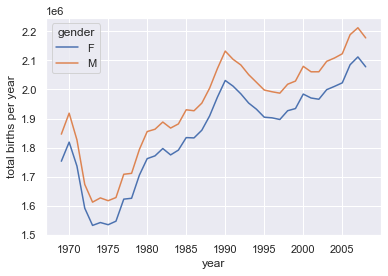

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index = 'year', columns = 'gender', aggfunc = 'sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and `plot()` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%

#### Removing Outliers
Next we start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th). One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation

In [25]:
# numpy.percentile(a, q)
# a: Input array
# q: Percentile or sequence of percentiles to compute, which must be between 0 and 100 inclusive
# find the 25%, 50% and 75% percentiles
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

With this we can use the `query()` method to filter-out rows with births outside these values

In [26]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

In [27]:
type(births['day'][0])

numpy.float64

Next we set the `day` column to integers

In [28]:
# set 'day' column to integer
births['day'] = births['day'].astype(int)

In [29]:
type(births['day'][0])

numpy.int64

Finally, we can combine the day, month, and year to create a Date index . This allows us to quickly compute the weekday corresponding to each row

In [30]:
# create a datetime index from the year, month, day
# datetimeIndex https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format = '%Y%m%d')

# Monday = 0, ..., Sunday = 6
births['dayofweek'] = birth.index.dayofweek
births

,year,month,day,gender,births,decade,dayofweek
1969-01-01,1969,1,1,F,4046,1960,2
1969-01-01,1969,1,1,M,4440,1960,2
1969-01-02,1969,1,2,F,4454,1960,3
1969-01-02,1969,1,2,M,4548,1960,3
1969-01-03,1969,1,3,F,4548,1960,4
...,...,...,...,...,...,...,...
1988-12-29,1988,12,29,M,5944,1980,3
1988-12-30,1988,12,30,F,5742,1980,4
1988-12-30,1988,12,30,M,6095,1980,4
1988-12-31,1988,12,31,F,4435,1980,5


Using this we can plot births by weekday for several decades

In [31]:
births.pivot_table('births', index = 'dayofweek',
                    columns = 'decade', aggfunc = 'mean')

decade,1960,1970,1980
dayofweek,,,
0,5063.826923,4689.097701,5276.907249
1,5286.096154,4885.252399,5503.842553
2,5074.622642,4750.376200,5367.642553
3,4978.288462,4696.923372,5333.485106
4,5107.884615,4782.095785,5393.087234
5,4651.057692,4207.784483,4483.901064
6,4342.346154,3979.278736,4308.120469


/var/folders/56/plm6ts814hj714s5vcdw5h040000gn/T/ipykernel_3247/2884497008.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


Text(0, 0.5, 'mean births by day')

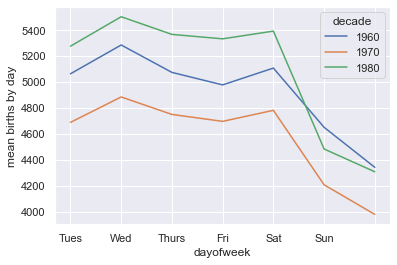

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index = 'dayofweek',
                    columns = 'decade', aggfunc = 'mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day')

Another intersting view is to plot the mean number of births by the day of the year. Let's first group the data by month and day separately

In [47]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

The result is a multi-index over months and days. To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [48]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

/var/folders/56/plm6ts814hj714s5vcdw5h040000gn/T/ipykernel_3247/4030178730.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day)


,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year. From this, we can use the plot method to plot the data. It reveals some interesting trends

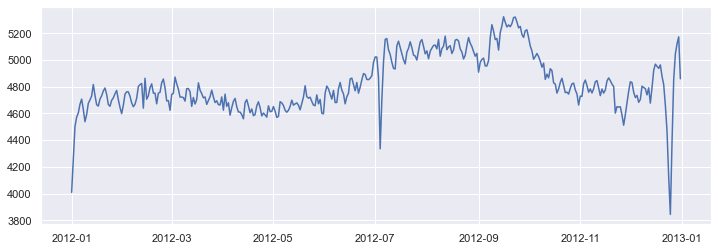

In [49]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(births_by_date)